In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import pathlib

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
SEED = 19011997
SPLIT_VAL = 0.2
SPLIT_TEST = 0.06
BATCH_SIZE = 16
IMG_SIZE = (256,256)

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='constant') # oppure "nearest"
    ]
)

In [5]:
path_dataset_training = pathlib.Path('./dataset/split_sick/training')
path_dataset_validation = pathlib.Path('./dataset/split_sick/validation')
path_dataset_testing = pathlib.Path('./dataset/split_sick/testing')

class_names = os.listdir(path_dataset_training)
print(class_names)

def import_from_directory(dataset_dir):
    return tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
        image_size=IMG_SIZE
    )

dataset_training = import_from_directory(path_dataset_training)
dataset_validation = import_from_directory(path_dataset_validation)
dataset_testing = import_from_directory(path_dataset_testing)

dataset_testing = dataset_testing.prefetch(buffer_size=64)
dataset_training = dataset_training.prefetch(buffer_size=64)
dataset_validation = dataset_validation.prefetch(buffer_size=64)

['Apple', 'Apple_sick', 'Blueberry', 'Cherry', 'Cherry_sick', 'Corn', 'Corn_sick', 'Grape', 'Grape_sick', 'Orange', 'Peach', 'Peach_sick', 'Pepper', 'Pepper_sick', 'Potato', 'Potato_sick', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Strawberry_sick', 'Tomato', 'Tomato_sick']
Found 13829 files belonging to 23 classes.
Found 3545 files belonging to 23 classes.
Found 354 files belonging to 23 classes.


In [6]:
images_count = {}
for name in class_names:
    count = len(list(path_dataset_training.glob('{}/*.jpg'.format(name))))
    images_count[name] = count

max_class = max(images_count.values())
class_weights = {}
i = 0
for name in class_names:
    class_weights[i] = max_class / images_count[name]
    i += 1
print(class_weights)

{0: 10.794270833333334, 1: 11.545961002785516, 2: 11.51388888888889, 3: 21.476683937823836, 4: 16.318897637795274, 5: 15.760456273764259, 6: 6.242469879518072, 7: 18.755656108597286, 8: 4.554945054945055, 9: 2.997107736804049, 10: 22.04787234042553, 11: 7.401785714285714, 12: 11.545961002785516, 13: 18.42222222222222, 14: 70.2542372881356, 15: 8.635416666666666, 16: 20.519801980198018, 17: 3.205723124516628, 18: 9.252232142857142, 19: 16.58, 20: 16.1284046692607, 21: 11.14247311827957, 22: 1.0}


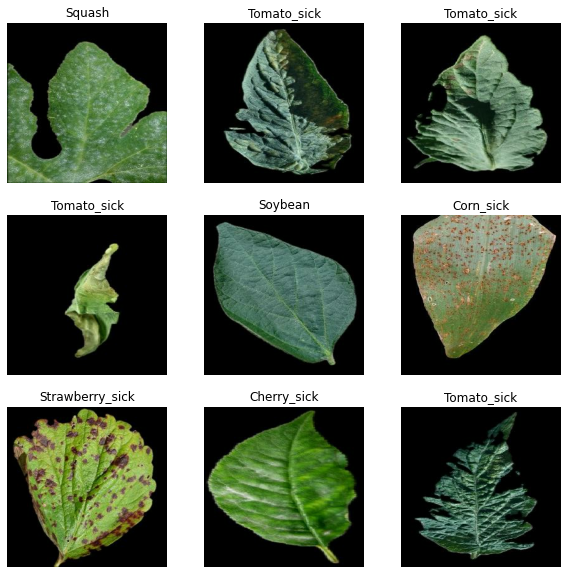

In [7]:
image_batch, label_batch = next(iter(dataset_training))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    index = np.argmax(np.array(label_batch[i]), axis=0)
    plt.title(class_names[index])
    plt.axis("off")

In [8]:
def make_base(input_Shape, trainable=False):
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        input_shape=input_Shape,
        include_top=False
    )

    base_model.trainable = trainable

    return base_model

def make_model(input_shape, num_classes, trainable=False):
    base_model = make_base(input_shape, trainable)
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = make_model(IMG_SIZE + (3,), len(class_names))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 23)                47127 

In [9]:
epochs = 24

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./models/sick/xception", save_best_only=True),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/24
433/433 [==============================] - 82s 156ms/step - loss: 7.7954 - accuracy: 0.7084 - mse: 0.0200 - val_loss: 0.6878 - val_accuracy: 0.8107 - val_mse: 0.0131
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/24
433/433 [==============================] - 60s 137ms/step - loss: 3.6586 - accuracy: 0.8364 - mse: 0.0113 - val_loss: 0.5440 - val_accuracy: 0.8429 - val_mse: 0.0107
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/24
433/433 [==============================] - 58s 133ms/step - loss: 2.7433 - accuracy: 0.8671 - mse: 0.0092 - val_loss: 0.3747 - val_accuracy: 0.8984 - val_mse: 0.0074
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/24
433/433 [==============================] - 61s 135ms/step - loss: 2.3048 - accuracy: 0.8857 - mse: 0.0079 - val_loss: 0.4122 - val_accuracy: 0.8714 - val_mse: 0.0084
Epoch 5/24
433/433 [==============================] - 58s 133ms/step - loss: 2.0613 - accuracy: 0.8925 - mse: 0.0073 - val_loss: 0.3184 - val_accuracy: 0.9047 - val_mse: 0.0065
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/24
433/433 [==============================] - 58s 131ms/step - loss: 1.8278 - accuracy: 0.9001 - mse: 0.0067 - val_loss: 0.2876 - val_accuracy: 0.9137 - val_mse: 0.0059
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/24
433/433 [==============================] - 55s 125ms/step - loss: 1.6843 - accuracy: 0.9020 - mse: 0.0064 - val_loss: 0.3014 - val_accuracy: 0.9004 - val_mse: 0.0064
Epoch 8/24
433/433 [==============================] - 59s 136ms/step - loss: 1.5702 - accuracy: 0.9059 - mse: 0.0062 - val_loss: 0.2696 - val_accuracy: 0.9179 - val_mse: 0.0057
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/24
433/433 [==============================] - 61s 137ms/step - loss: 1.4850 - accuracy: 0.9138 - mse: 0.0058 - val_loss: 0.2742 - val_accuracy: 0.9114 - val_mse: 0.0058
Epoch 10/24
433/433 [==============================] - 57s 132ms/step - loss: 1.4353 - accuracy: 0.9176 - mse: 0.0055 - val_loss: 0.2560 - val_accuracy: 0.9188 - val_mse: 0.0055
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/24
433/433 [==============================] - 57s 130ms/step - loss: 1.3535 - accuracy: 0.9197 - mse: 0.0054 - val_loss: 0.2681 - val_accuracy: 0.9126 - val_mse: 0.0058
Epoch 12/24
433/433 [==============================] - 59s 135ms/step - loss: 1.2651 - accuracy: 0.9231 - mse: 0.0053 - val_loss: 0.2588 - val_accuracy: 0.9173 - val_mse: 0.0056
Epoch 13/24
433/433 [==============================] - 59s 136ms/step - loss: 1.2587 - accuracy: 0.9213 - mse: 0.0052 - val_loss: 0.2613 - val_accuracy: 0.9114 - val_mse: 0.0056
Epoch 14/24
433/433 [==============================] - 59s 136ms/step - loss: 1.2165 - accuracy: 0.9218 - mse: 0.0051 - val_loss: 0.2327 - val_accuracy: 0.9219 - val_mse: 0.0051
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/24
433/433 [==============================] - 59s 134ms/step - loss: 1.1666 - accuracy: 0.9270 - mse: 0.0049 - val_loss: 0.2068 - val_accuracy: 0.9329 - val_mse: 0.0044
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/24
433/433 [==============================] - 57s 130ms/step - loss: 1.1546 - accuracy: 0.9299 - mse: 0.0048 - val_loss: 0.2436 - val_accuracy: 0.9182 - val_mse: 0.0053
Epoch 17/24
433/433 [==============================] - 56s 128ms/step - loss: 0.9835 - accuracy: 0.9340 - mse: 0.0044 - val_loss: 0.1992 - val_accuracy: 0.9362 - val_mse: 0.0043
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/24
433/433 [==============================] - 56s 129ms/step - loss: 1.0302 - accuracy: 0.9326 - mse: 0.0044 - val_loss: 0.2050 - val_accuracy: 0.9298 - val_mse: 0.0045
Epoch 19/24
433/433 [==============================] - 57s 131ms/step - loss: 1.0224 - accuracy: 0.9324 - mse: 0.0045 - val_loss: 0.2406 - val_accuracy: 0.9173 - val_mse: 0.0053
Epoch 20/24
433/433 [==============================] - 58s 133ms/step - loss: 0.9866 - accuracy: 0.9307 - mse: 0.0045 - val_loss: 0.1808 - val_accuracy: 0.9425 - val_mse: 0.0039
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/24
433/433 [==============================] - 56s 127ms/step - loss: 0.9632 - accuracy: 0.9328 - mse: 0.0044 - val_loss: 0.1785 - val_accuracy: 0.9433 - val_mse: 0.0038
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/24
433/433 [==============================] - 58s 131ms/step - loss: 0.9718 - accuracy: 0.9325 - mse: 0.0044 - val_loss: 0.1761 - val_accuracy: 0.9422 - val_mse: 0.0038
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/24
433/433 [==============================] - 66s 150ms/step - loss: 0.9348 - accuracy: 0.9345 - mse: 0.0042 - val_loss: 0.1622 - val_accuracy: 0.9456 - val_mse: 0.0035
INFO:tensorflow:Assets written to: ./models/sick\xception\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/24
433/433 [==============================] - 55s 127ms/step - loss: 0.9581 - accuracy: 0.9359 - mse: 0.0042 - val_loss: 0.1748 - val_accuracy: 0.9450 - val_mse: 0.0038


In [11]:
model.save_weights('./models/sick/xception-w/weights')

In [10]:
finemodel = make_model(IMG_SIZE + (3,), len(class_names), True)
finemodel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 23)                4712

In [13]:
finemodel.load_weights('./models/sick/xception-w/weights')

finemodel.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

# finemodel.evaluate(dataset_testing)
finemodel.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=8,
    class_weight=class_weights
)

Epoch 1/8
865/865 [==============================] - 249s 280ms/step - loss: 0.7060 - accuracy: 0.9481 - mse: 0.0034 - val_loss: 0.1246 - val_accuracy: 0.9630 - val_mse: 0.0025
Epoch 2/8
865/865 [==============================] - 233s 268ms/step - loss: 0.5124 - accuracy: 0.9619 - mse: 0.0025 - val_loss: 0.1301 - val_accuracy: 0.9622 - val_mse: 0.0026
Epoch 3/8
865/865 [==============================] - 239s 275ms/step - loss: 0.2957 - accuracy: 0.9753 - mse: 0.0016 - val_loss: 0.0717 - val_accuracy: 0.9772 - val_mse: 0.0015
Epoch 4/8
865/865 [==============================] - 233s 268ms/step - loss: 0.3245 - accuracy: 0.9800 - mse: 0.0014 - val_loss: 0.2020 - val_accuracy: 0.9315 - val_mse: 0.0044
Epoch 5/8
865/865 [==============================] - 228s 263ms/step - loss: 0.1958 - accuracy: 0.9826 - mse: 0.0012 - val_loss: 0.0608 - val_accuracy: 0.9811 - val_mse: 0.0012
Epoch 6/8
865/865 [==============================] - 228s 263ms/step - loss: 0.1595 - accuracy: 0.9852 - mse: 9.753

In [14]:
finemodel.save('./models/sick/xception-fine')

INFO:tensorflow:Assets written to: ./models/sick/xception-fine\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [15]:
finemodel.save_weights('./models/sick/xception-w/fine')

In [13]:
testmodel = tf.keras.models.load_model('./models/sick/xception-fine')
testmodel.evaluate(dataset_testing)

12/12 [==============================] - 3s 137ms/step - loss: 0.0275 - accuracy: 0.9859 - mse: 0.0012


[0.027521895244717598, 0.9858757257461548, 0.0012148699024692178]